In [1]:
import pandas as pd
from unidecode import unidecode
from model2vec import StaticModel
import matplotlib.pyplot as plt
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
df_data = pd.read_csv('../data/sale_data/1_sale_clean.csv')
df_data['house_id']='house_'+df_data.index.astype(str)
df_data.head(2)

,citta,bagni,stanze,piano,regione,m2,quartiere,description,via,disponibilità,prezzo,locali,delta_pubblicazione,totale_piani,ascensore,cucina,camere,tipologia_casa,classe_casa,tipologia_proprietà,n posti auto,box privato,balcone,impianto tv singolo,porta blindata,parzialmente arredato,cantina,esposizione doppia,arredato,caminetto,terrazza,impianto di allarme,portiere,piscina_idromassaggio,videocitofono,cancello elettrico,fibra ottica,armadio a muro,impianto tv centralizzato,mansarda,giardino,infissi,house_id
0,Rosignano Marittimo,1,4,1,toscana,100,Piazza Pietro Gori,ROSIGNANO MARITTIMO – OTTIMO APPARTAMENTO IN C...,missing,Libero,123000.00,4,0,2,0,cucina abitabile,2,Appartamento,Classe immobile media,Intera proprietà,0,False,False,True,True,True,False,True,True,False,False,False,Missing,Missing,False,False,False,False,False,False,Missing,doppio,house_0
1,Milano,1,5,3,lombardia,100,Certosa,"ACCURSIO/CERTOSA, VIA MICHELINO DA BESOZZO, MI...",Via Michelino da Besozzo,Libero,345000.00,5,1,8,1,cucina abitabile,3,Appartamento,Classe immobile media,Intera proprietà,0,False,True,False,True,False,True,True,False,False,False,False,portiere presente,Missing,False,False,True,False,True,False,Missing,singolo,house_1


### Aggiunta Popolazione e Reddito

In [3]:
abitanti = pd.read_csv('../data/feature_data/abitanti.csv')
abitanti['DESCRIZIONE COMUNE'] = abitanti['DESCRIZIONE COMUNE'].str.replace("'","").str.lower()
abitanti.rename({'DESCRIZIONE COMUNE':'citta', 'POPOLAZIONE CENSITA TOTALE':'popolazione'}, axis=1, inplace=True)
abitanti['popolazione']=abitanti['popolazione'].str.replace('.','').astype(int)
abitanti.head(2)

,citta,POPOLAZIONE CENSITA UOMINI,POPOLAZIONE CENSITA DONNE,popolazione
0,abano terme,9.556,10.567,20123
1,abbadia cerreto,139,136,275


In [4]:
fix_citta_dict = {'Reggio Emilia': 'REGGIO NELLEMILIA', 'Montemagno':'MONTEMAGNO MONFERRATO', 
             'Calatafimi-Segesta':'CALATAFIMI SEGESTA','Giardini-Naxos':'GIARDINI NAXOS', 'Trentola-Ducenta':'TRENTOLA DUCENTA', 
             'Bolzano':'BOLZANO/BOZEN', 'Appiano sulla Strada del Vino':'APPIANO SULLA STRADA DEL VINO/EPPAN AN DER WEINSTRASSE', 
             'Laives':'LAIVES/LEIFERS', 'Merano':'MERANO/MERAN', 'Montescudo - Montecolombo':'MONTESCUDO - MONTE COLOMBO', 
             'Crespina e Lorenzana':'CRESPINA LORENZANA'}

def fix_citta(city):
    if city in fix_citta_dict.keys():
        return fix_citta_dict[city]
    return city

In [5]:
df_data['citta'] = df_data['citta'].map(unidecode).str.replace("'","").map(fix_citta).str.lower()
df_data = pd.merge(df_data, abitanti[['citta', 'popolazione']], how='left', on='citta')
df_data.loc[df_data['popolazione'].isna(), 'popolazione']=-1

In [6]:
reddito = pd.read_csv('../data/feature_data/reddito_by_regione.csv')
reddito = reddito[reddito['T_D8']=='REDD_MEDIANO_FAM'][['Territorio', 'Value']].rename({'Territorio':'regione', 'Value':'reddito mediano'}, axis=1)
reddito['regione'] = reddito['regione'].str.lower()
df_data = pd.merge(df_data, reddito, how='left', on='regione')

### Valutazione description

In [7]:
model = StaticModel.from_pretrained("minishlab/m2v_multilingual_output")

c:\Users\faceru\OneDrive - SAS\Documents\Personal\Italy_House_Prices\housing_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
embeddings = model.encode(df_data['description'])
embeddings = pd.DataFrame(embeddings, columns=[f'emb_{i}' for i in range(embeddings.shape[1])])
df_data_full = pd.concat([df_data, embeddings], axis=1)
df_data_full.drop('description', inplace=True, axis=1)

### Log Transform

In [9]:
df_data_full[['prezzo', 'm2']].describe(percentiles=[i/10 for i in range(1,10)])

,prezzo,m2
count,16243.00,16243.00
mean,581011.73,185.09
std,10696636.95,1554.08
min,1.00,1.00
10%,114000.00,65.00
20%,155000.00,80.00
30%,195000.00,90.00
40%,238000.00,102.00
50%,280000.00,116.00
60%,338000.00,132.00


In [10]:
min_price = 10000
min_m2 = 20
max_price = 10000000
max_m2 = 1000
n_obs_orig = df_data_full.shape[0]
df_data_full_clean = df_data_full[(df_data_full['prezzo'].between(min_price, max_price, inclusive='both'))&(df_data_full['m2'].between(min_m2, max_m2, inclusive='both'))].reset_index(drop=True)
n_obs_new = df_data_full_clean.shape[0]
print(f'Keeping {min_price}<=Price<={max_price} and {min_m2}<=M2<={max_m2}', f'---> {n_obs_orig-n_obs_new} observations dropped')
df_data_full_clean[['prezzo', 'm2']].describe(percentiles=[i/10 for i in range(1,10)])

Keeping 10000<=Price<=10000000 and 20<=M2<=1000 ---> 167 observations dropped


,prezzo,m2
count,16076.00,16076.00
mean,426675.87,147.02
std,565172.69,109.34
min,10000.00,20.00
10%,113000.00,65.00
20%,155000.00,80.00
30%,190000.00,90.00
40%,235000.00,101.00
50%,279000.00,116.00
60%,335000.00,130.00


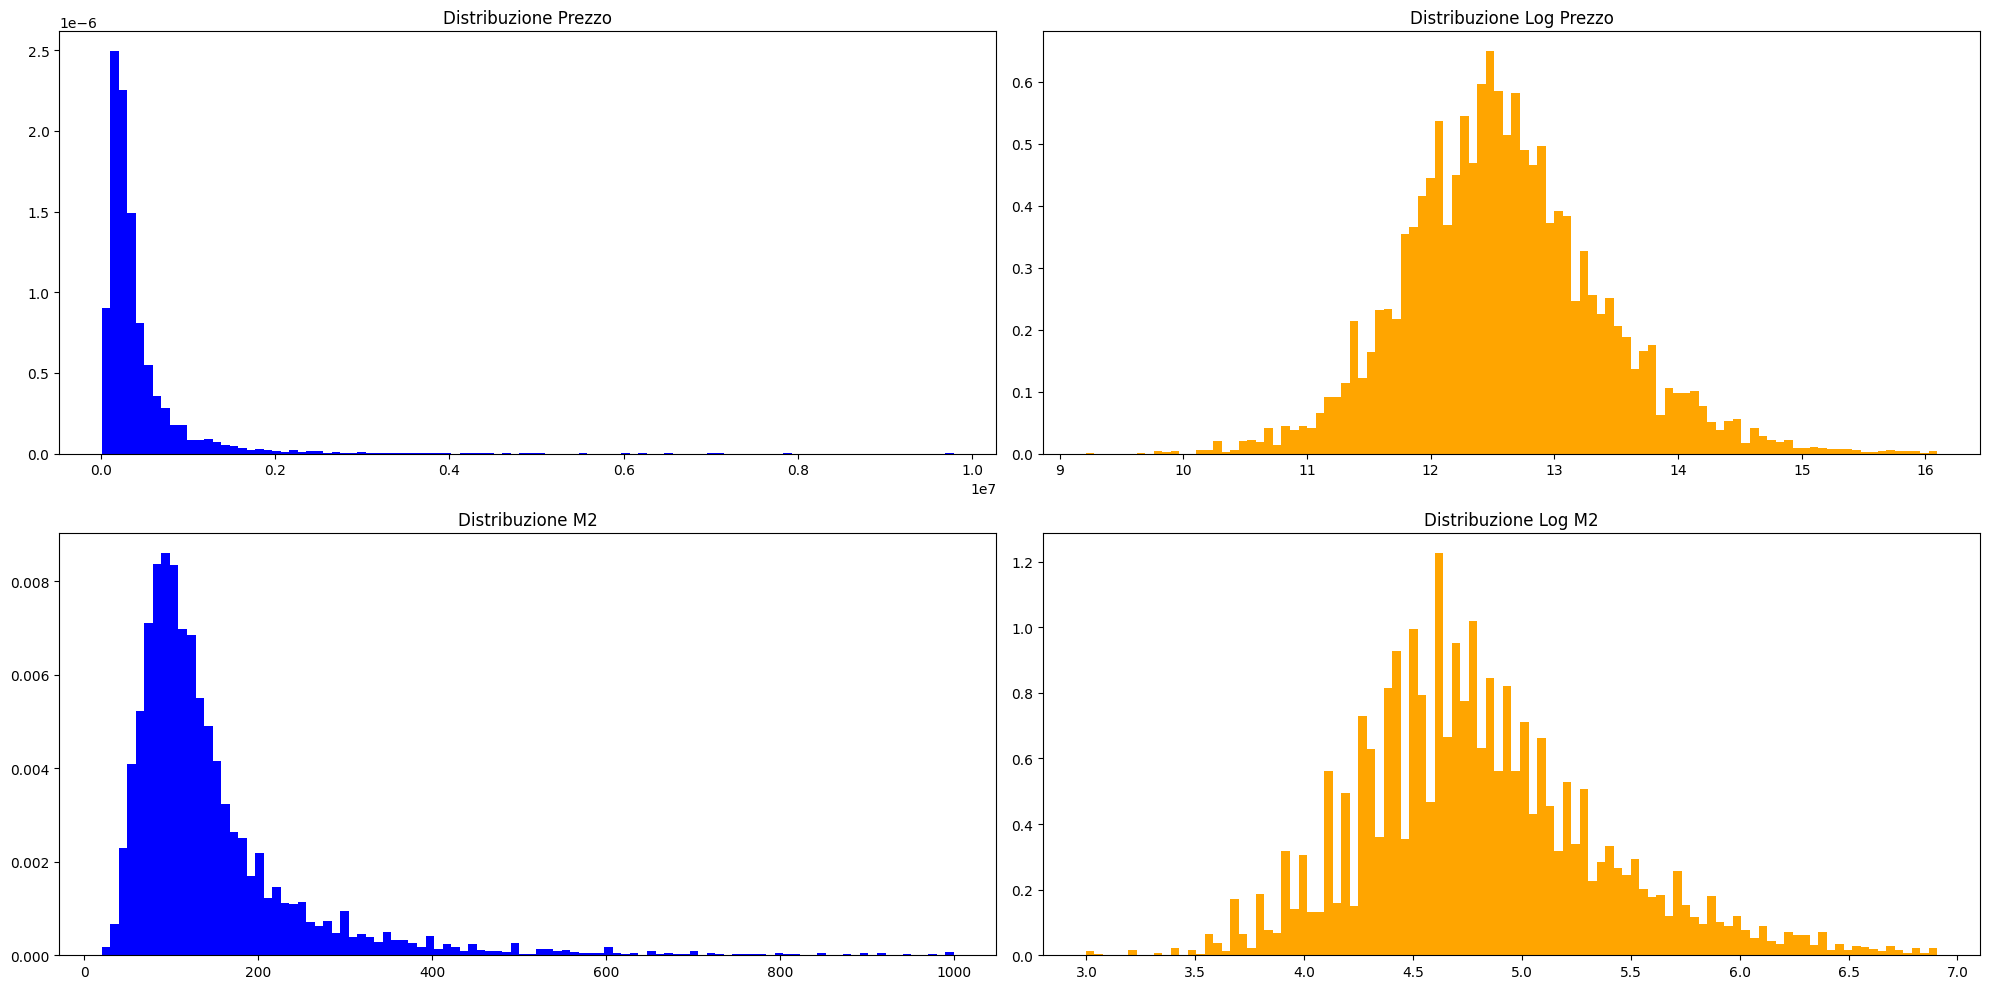

In [11]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20,10))
ax=axs.ravel()
ax[0].hist(df_data_full_clean['prezzo'], bins=100, color='blue', density=True)
ax[0].set_title('Distribuzione Prezzo')
ax[1].hist(np.log(df_data_full_clean['prezzo']), bins=100, color='orange', density=True)
ax[1].set_title('Distribuzione Log Prezzo')
ax[2].hist(df_data_full_clean['m2'], bins=100, color='blue', density=True)
ax[2].set_title('Distribuzione M2')
ax[3].hist(np.log(df_data_full_clean['m2']), bins=100, color='orange', density=True)
ax[3].set_title('Distribuzione Log M2')
plt.tight_layout()
plt.show()

In [12]:
df_data_full_clean['log_prezzo']=np.log(df_data_full_clean['prezzo'])
df_data_full_clean['log_m2']=np.log(df_data_full_clean['m2'])

### Save

In [13]:
df_data_full_clean.to_csv('../data/sale_data/2_sale_enriched.csv', index=False)